In [ ]:
import numpy as np

import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import *
from keras.models import Sequential, Model, load_model
from tensorflow.keras import mixed_precision
import keras.backend as K
import pandas as pd
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import splitfolders
import zipfile
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
import shutil
import sys
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import locale
locale.setlocale(locale.LC_ALL, 'bn_BD.UTF-8')
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import seaborn as sn

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [ ]:
grapheme_roots = df['grapheme_root'].values
n, c = np.unique(grapheme_roots, return_counts=True)
total_grapheme_roots = len(n)
print(total_grapheme_roots, 'total_grapheme_roots')


vowel_diacritic = df['vowel_diacritic'].values
n, c = np.unique(vowel_diacritic, return_counts=True)
total_vowel_diacritic = len(n)
print(total_vowel_diacritic, 'total_vowel_diacritic')


consonant_diacritic = df['consonant_diacritic'].values
n, c = np.unique(consonant_diacritic, return_counts=True)
total_consonant_diacritic = len(n)
print(total_consonant_diacritic, 'total_consonant_diacritic')


168 total_grapheme_roots
11 total_vowel_diacritic
7 total_consonant_diacritic


In [ ]:
df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [ ]:
X = df['image_id']
X

0              Train_0
1              Train_1
2              Train_2
3              Train_3
4              Train_4
              ...     
200835    Train_200835
200836    Train_200836
200837    Train_200837
200838    Train_200838
200839    Train_200839
Name: image_id, Length: 200840, dtype: object

In [ ]:
y = df.drop(['image_id'], axis=1)
y

,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,15,9,5,ক্ট্রো
1,159,0,0,হ
2,22,3,5,খ্রী
3,53,2,2,র্টি
4,71,9,5,থ্রো
...,...,...,...,...
200835,22,7,2,র্খে
200836,65,9,0,ত্তো
200837,2,1,4,অ্যা
200838,152,9,0,স্নো


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
def augment_image(img):
    data_augmentation = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0,
        height_shift_range=0,
        zoom_range=0,
        fill_mode='constant', cval=0,
        horizontal_flip=False,
        vertical_flip=False
    )
    img = data_augmentation.random_transform(img)
    return img

In [ ]:
batch_size = 128

def loader(img_list, img_labels,augment=True):
    L = len(img_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            z = np.zeros((len(img_list[batch_start:limit]), 200, 200, 1))
            for i, f in enumerate(img_list[batch_start:limit]):
                img = tf.keras.utils.load_img('./images/'+f+'.jpg', color_mode='grayscale',target_size=(200, 200))
                img = tf.keras.utils.img_to_array(img)/255.
                if augment:
                    img = augment_image(img)
                z[i, :, :, :] = img
            X = z
            labels = img_labels[batch_start:limit]

            Y = []

            grapheme_roots = []
            vowel_diacritics = []
            consonant_diacritics = []
            for label in labels:
                grapheme_roots.append(label[0])
                vowel_diacritics.append(label[1])
                consonant_diacritics.append(label[2])

            grapheme_roots = np.array(grapheme_roots)
            vowel_diacritics = np.array(vowel_diacritics)
            consonant_diacritics = np.array(consonant_diacritics)

            yield (X,{'grapheme_root': grapheme_roots, 'vowel_diacritic': vowel_diacritics, 'consonant_diacritic': consonant_diacritics})
            batch_start += batch_size
            batch_end += batch_size

In [ ]:
train_generator = loader(X_train.values, y_train.values)
val_generator = loader(X_val.values, y_val.values)

In [ ]:
def simple_model():

    f = 16
    x = Input(shape=(200,200,1,))
    init=x

    conv = Conv2D(f, 3, strides=1, padding='same', activation='relu')(init)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*2, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*4, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*8, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)


    conv = Conv2D(f*16, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    f = Flatten()(conv)

    d_grapheme_root = Dense(512, activation='relu')(f)
    d_grapheme_root = Dropout(0.5)(d_grapheme_root)
    d_grapheme_root = Dense(256, activation='relu')(d_grapheme_root)

    d_vowel_diacritic = Dense(512, activation='relu')(f)
    d_vowel_diacritic = Dropout(0.5)(d_vowel_diacritic)
    d_vowel_diacritic = Dense(256, activation='relu')(d_vowel_diacritic)

    d_consonant_diacritic = Dense(512, activation='relu')(f)
    d_consonant_diacritic = Dropout(0.5)(d_consonant_diacritic)
    d_consonant_diacritic = Dense(256, activation='relu')(d_consonant_diacritic)


    grapheme_root = Dense(total_grapheme_roots, activation='softmax', name='grapheme_root')(d_grapheme_root)
    vowel_diacritic = Dense(total_vowel_diacritic, activation='softmax', name='vowel_diacritic')(d_vowel_diacritic)
    consonant_diacritic = Dense(total_consonant_diacritic, activation='softmax', name='consonant_diacritic')(d_consonant_diacritic)


    model = Model(inputs=x, outputs=[grapheme_root, vowel_diacritic, consonant_diacritic])

    return model

model = simple_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 100, 100, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
media_start = './'
optimizer = Adam(0.001)

model_path = media_start+"test.hdf5"

checkpoint = ModelCheckpoint(model_path, save_freq="epoch",save_best_only=True,
    save_weights_only=False, monitor='val_loss', verbose=1)

csv_logger = CSVLogger(media_start+"log.csv")

ce = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

model.compile(optimizer = optimizer, loss=ce, metrics = ['accuracy'])

train_steps = len(X_train)//batch_size
val_steps = len(X_val)//batch_size

def scheduler(epoch):
    initial = 0.001
    lr = initial
    if epoch >= 10:
        lr = 0.0001
    return lr


scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

history = model.fit(train_generator,
        steps_per_epoch=train_steps,
        epochs=30,
        verbose=1,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[checkpoint, csv_logger, scheduler_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
1129/1129 [==============================] - ETA: 0s - loss: 4.8209 - grapheme_root_loss: 3.4475 - vowel_diacritic_loss: 0.7882 - consonant_diacritic_loss: 0.5852 - grapheme_root_accuracy: 0.1990 - vowel_diacritic_accuracy: 0.7219 - consonant_diacritic_accuracy: 0.8050
Epoch 1: val_loss improved from inf to 1.99805, saving model to .\test.hdf5
1129/1129 [==============================] - 2710s 2s/step - loss: 4.8209 - grapheme_root_loss: 3.4475 - vowel_diacritic_loss: 0.7882 - consonant_diacritic_loss: 0.5852 - grapheme_root_accuracy: 0.1990 - vowel_diacritic_accuracy: 0.7219 - consonant_diacritic_accuracy: 0.8050 - val_loss: 1.9980 - val_grapheme_root_loss: 1.5020 - val_vowel_diacritic_loss: 0.2491 - val_consonant_diacritic_loss: 0.2470 - val_grapheme_root_accuracy: 0.5778 - val_vowel_diacritic_accuracy: 0.9169 - val_consonant_diacritic_accuracy: 0.9161 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learn


Epoch 10: LearningRateScheduler setting learning rate to 0.001.
Epoch 10/30
1129/1129 [==============================] - ETA: 0s - loss: 0.4788 - grapheme_root_loss: 0.3674 - vowel_diacritic_loss: 0.0618 - consonant_diacritic_loss: 0.0497 - grapheme_root_accuracy: 0.8834 - vowel_diacritic_accuracy: 0.9793 - consonant_diacritic_accuracy: 0.9832
Epoch 10: val_loss did not improve from 0.84506
1129/1129 [==============================] - 2735s 2s/step - loss: 0.4788 - grapheme_root_loss: 0.3674 - vowel_diacritic_loss: 0.0618 - consonant_diacritic_loss: 0.0497 - grapheme_root_accuracy: 0.8834 - vowel_diacritic_accuracy: 0.9793 - consonant_diacritic_accuracy: 0.9832 - val_loss: 0.8646 - val_grapheme_root_loss: 0.5557 - val_vowel_diacritic_loss: 0.1511 - val_consonant_diacritic_loss: 0.1578 - val_grapheme_root_accuracy: 0.8493 - val_vowel_diacritic_accuracy: 0.9619 - val_consonant_diacritic_accuracy: 0.9604 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0001.
Epoch


Epoch 19: LearningRateScheduler setting learning rate to 0.0001.
Epoch 19/30
1129/1129 [==============================] - ETA: 0s - loss: 0.1640 - grapheme_root_loss: 0.1394 - vowel_diacritic_loss: 0.0144 - consonant_diacritic_loss: 0.0103 - grapheme_root_accuracy: 0.9528 - vowel_diacritic_accuracy: 0.9954 - consonant_diacritic_accuracy: 0.9964
Epoch 19: val_loss did not improve from 0.83465
1129/1129 [==============================] - 2737s 2s/step - loss: 0.1640 - grapheme_root_loss: 0.1394 - vowel_diacritic_loss: 0.0144 - consonant_diacritic_loss: 0.0103 - grapheme_root_accuracy: 0.9528 - vowel_diacritic_accuracy: 0.9954 - consonant_diacritic_accuracy: 0.9964 - val_loss: 0.9733 - val_grapheme_root_loss: 0.5402 - val_vowel_diacritic_loss: 0.1991 - val_consonant_diacritic_loss: 0.2340 - val_grapheme_root_accuracy: 0.8778 - val_vowel_diacritic_accuracy: 0.9664 - val_consonant_diacritic_accuracy: 0.9631 - lr: 1.0000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001.



Epoch 28: LearningRateScheduler setting learning rate to 0.0001.
Epoch 28/30
1129/1129 [==============================] - ETA: 0s - loss: 0.1160 - grapheme_root_loss: 0.1016 - vowel_diacritic_loss: 0.0083 - consonant_diacritic_loss: 0.0061 - grapheme_root_accuracy: 0.9654 - vowel_diacritic_accuracy: 0.9970 - consonant_diacritic_accuracy: 0.9979
Epoch 28: val_loss did not improve from 0.83465
1129/1129 [==============================] - 2727s 2s/step - loss: 0.1160 - grapheme_root_loss: 0.1016 - vowel_diacritic_loss: 0.0083 - consonant_diacritic_loss: 0.0061 - grapheme_root_accuracy: 0.9654 - vowel_diacritic_accuracy: 0.9970 - consonant_diacritic_accuracy: 0.9979 - val_loss: 1.0977 - val_grapheme_root_loss: 0.5809 - val_vowel_diacritic_loss: 0.2449 - val_consonant_diacritic_loss: 0.2718 - val_grapheme_root_accuracy: 0.8782 - val_vowel_diacritic_accuracy: 0.9660 - val_consonant_diacritic_accuracy: 0.9630 - lr: 1.0000e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0001.


In [ ]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [ ]:
# # FOR RECONSTRUCTION PURPOSE
# df_gr = pd.read_csv('train.csv')
# df_gr = df_gr.drop_duplicates(subset=['grapheme'])
# dv = df_gr.values
# grapheme_roots = {}
# _grapheme_roots = []

# vowel_diacritics = []
# _vowel_diacritics = []

# consonant_diacritics = []
# _consonant_diacritics = []
# for v in dv:
#     if v[1] != 0 and v[2] == 0 and v[3] == 0 and v[-1] not in _grapheme_roots:
#         _grapheme_roots.append(v[-1])
#         grapheme_roots[v[1]] =v[-1]


In [ ]:
# FOR RECONSTRUCTION PURPOSE
df_gr = pd.read_csv('train.csv')
df_gr = df_gr.drop_duplicates(subset=['grapheme'])
dv = df_gr.values
grapheme_roots = []
_grapheme_roots = []

for v in dv:
    if v[1] != 0 and v[2] == 0 and v[3] == 0 and v[-1] not in _grapheme_roots:
        _grapheme_roots.append(v[-1])
        grapheme_roots.append({'numeric': v[1], 'value': v[-1]})

vowel_diacritics = {}
vowel_diacritics[0] = ''
vowel_diacritics[1] = 'া'
vowel_diacritics[2] = 'ি'
vowel_diacritics[3] = 'ী'
vowel_diacritics[4] = 'ু'
vowel_diacritics[5] = 'ূ'
vowel_diacritics[6] = 'ৃ'
vowel_diacritics[7] = 'ে'
vowel_diacritics[8] = 'ৈ'
vowel_diacritics[9] = 'ো'
vowel_diacritics[10] = 'ৌ'


consonant_diacritics = {}
consonant_diacritics[0] = ''
consonant_diacritics[1] = 'ঁ'
consonant_diacritics[2] = '\u09b0\u09cd'
consonant_diacritics[3] = '্য' #//ref + ja fala
consonant_diacritics[4] = '্য'
consonant_diacritics[5] = '্র'
consonant_diacritics[6] = '্র্য'
consonant_diacritics[7] = '্র' #ref + ra fala


def get_grapheme_root(numeric):
    for item in grapheme_roots:
        if item['numeric'] == numeric:
            return item['value']
    return ''

def get_vowel_diacritic(numeric):
    global vowel_diacritics
    return vowel_diacritics[numeric]

def get_consonant_diacritic(numeric):
    global consonant_diacritics
    return consonant_diacritics[numeric]

consonant_middle=[5,4,6]
consonant_after=[1]
consonant_before=[2]
consonant_combined=[3,7]
def get_grapheme(gr,vd,cd):
    consonant_middle=[5,4,6]
    consonant_after=[1]
    consonant_before=[2]
    consonant_combined=[3,7]

    if cd==0:
        return get_grapheme_root(gr)+get_vowel_diacritic(vd)
    elif cd in consonant_middle:
        return get_grapheme_root(gr)+get_consonant_diacritic(cd)+get_vowel_diacritic(vd)
    elif cd in consonant_before: #ref
        return get_consonant_diacritic(cd)+get_grapheme_root(gr)+get_vowel_diacritic(vd)
    elif cd in consonant_combined :#ref+ ja fala

        return '\u09b0\u09cd'+get_grapheme_root(gr)+get_consonant_diacritic(cd)+get_vowel_diacritic(vd)

    elif cd in consonant_after:
        return get_grapheme_root(gr)+get_vowel_diacritic(vd)+get_consonant_diacritic(cd)

In [ ]:
model.load_weights('saved_model')

y_true_grapheme_root = []
y_true_vowel_diacritic = []
y_true_consonant_diacritic = []

y_pred_grapheme_root = []
y_pred_vowel_diacritic = []
y_pred_consonant_diacritic = []

for i, f in tqdm(enumerate(X_test)):
    img = tf.keras.utils.load_img('./images/'+f+'.jpg', color_mode='grayscale',target_size=(200, 200))
    img = tf.keras.utils.img_to_array(img)/255.
    img = np.expand_dims(img, axis=0)
    pr = model.predict(img, verbose=0)

    pred_grapheme_root = np.argmax(pr[0], axis=-1)[0]
    pred_vowel_diacritic = np.argmax(pr[1], axis=-1)[0]
    pred_consonant_diacritic = np.argmax(pr[2], axis=-1)[0]


    true_grapheme_root = y_test['grapheme_root'].iloc[i]
    true_vowel_diacritic = y_test['vowel_diacritic'].iloc[i]
    true_consonant_diacritic = y_test['consonant_diacritic'].iloc[i]


    y_pred_grapheme_root.append(pred_grapheme_root)
    y_pred_vowel_diacritic.append(pred_vowel_diacritic)
    y_pred_consonant_diacritic.append(np.argmax(pr[2], axis=-1)[0])

    y_true_grapheme_root.append(y_test['grapheme_root'].iloc[i])
    y_true_vowel_diacritic.append(y_test['vowel_diacritic'].iloc[i])
    y_true_consonant_diacritic.append(y_test['consonant_diacritic'].iloc[i])


20084it [2:44:42,  2.03it/s]


In [ ]:
print(classification_report(y_true_grapheme_root, y_pred_grapheme_root, digits=5))

              precision    recall  f1-score   support

           0    0.77778   0.93333   0.84848        15
           1    0.81250   0.86667   0.83871        15
           2    0.93750   0.88235   0.90909        34
           3    0.80556   0.90625   0.85294        32
           4    0.89189   1.00000   0.94286        33
           5    0.82353   0.82353   0.82353        17
           6    0.84848   0.90323   0.87500        31
           7    0.85714   0.80000   0.82759        15
           8    0.82353   0.87500   0.84848        16
           9    0.82979   0.86667   0.84783        45
          10    0.80000   0.80000   0.80000        15
          11    0.71429   1.00000   0.83333        15
          12    0.93333   0.93333   0.93333        15
          13    0.91544   0.92052   0.91797       541
          14    0.93671   0.93671   0.93671        79
          15    0.94545   0.96296   0.95413       108
          16    0.92045   0.88043   0.90000        92
          17    0.94521   0

In [ ]:
print(classification_report(y_true_vowel_diacritic, y_pred_vowel_diacritic, digits=5))

              precision    recall  f1-score   support

           0    0.93865   0.96449   0.95139      4140
           1    0.97032   0.96558   0.96794      3690
           2    0.99272   0.99884   0.99577      2595
           3    0.98320   0.97651   0.97984      1618
           4    0.96490   0.94600   0.95536      1889
           5    0.96701   0.88158   0.92232       532
           6    0.94601   0.93072   0.93830       433
           7    0.96579   0.97353   0.96964      2871
           8    0.96933   0.89266   0.92941       354
           9    0.94828   0.95890   0.95356      1606
          10    0.98198   0.91854   0.94920       356

    accuracy                        0.96420     20084
   macro avg    0.96620   0.94612   0.95571     20084
weighted avg    0.96438   0.96420   0.96414     20084



In [ ]:
print(classification_report(y_true_consonant_diacritic, y_pred_consonant_diacritic, digits=5))

              precision    recall  f1-score   support

           0    0.96239   0.98588   0.97399     12536
           1    0.98331   0.95155   0.96717       743
           2    0.95478   0.92869   0.94156      2342
           3    0.96429   0.88525   0.92308        61
           4    0.97012   0.94774   0.95880      2124
           5    0.96593   0.90178   0.93275      2138
           6    0.97458   0.82143   0.89147       140

    accuracy                        0.96350     20084
   macro avg    0.96791   0.91747   0.94126     20084
weighted avg    0.96356   0.96350   0.96323     20084



<Axes: >

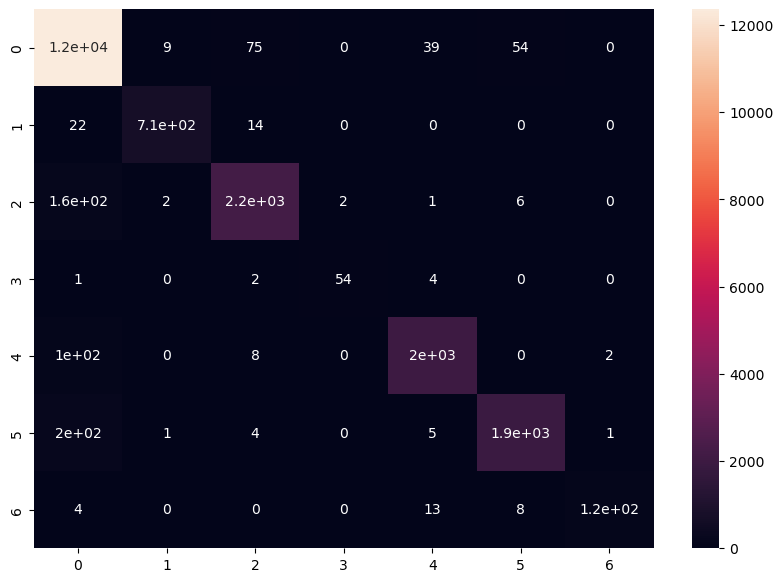

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_true_consonant_diacritic, y_pred_consonant_diacritic), annot=True)

<Axes: >

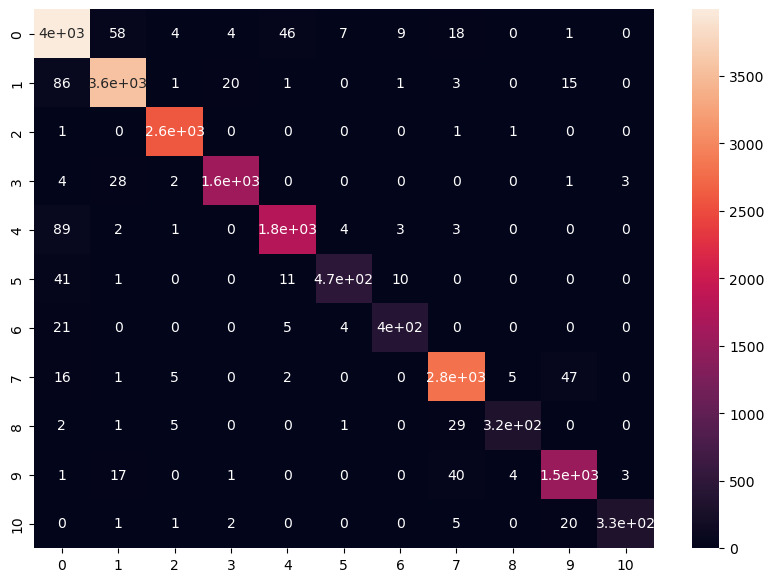

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_true_vowel_diacritic, y_pred_vowel_diacritic), annot=True)

In [ ]:
new_csv = pd.read_csv('new.csv')
X_test_new = new_csv['image_id']
y_new = df.drop(['image_id'], axis=1)

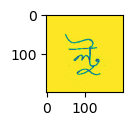

Grapheme :  ল্টু


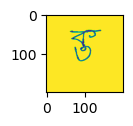

Grapheme :  ন্ড


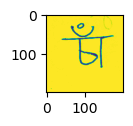

Grapheme :  চাঁ


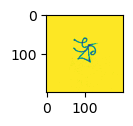

Grapheme :  ঙ্ক


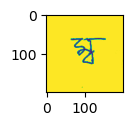

Grapheme :  ম্ব


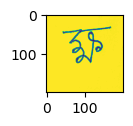

Grapheme :  ক্ষ


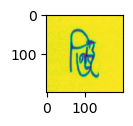

Grapheme :  ঞ্জি


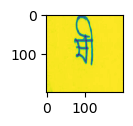

Grapheme :  ষী


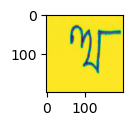

Grapheme :  ত্থ


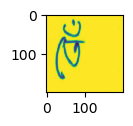

Grapheme :  তেঁ


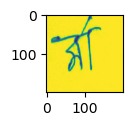

Grapheme :  র্মা


In [ ]:
y_true_grapheme_root_new = []
y_true_vowel_diacritic_new = []
y_true_consonant_diacritic_new = []

y_pred_grapheme_root_new = []
y_pred_vowel_diacritic_new = []
y_pred_consonant_diacritic_new = []

for i, f in enumerate(X_test_new):
    img = tf.keras.utils.load_img('./new/'+f+'.jpg', color_mode='grayscale',target_size=(200, 200))
    img = tf.keras.utils.img_to_array(img)/255.
    img = np.expand_dims(img, axis=0)
    pr = model.predict(img, verbose=0)

    pred_grapheme_root = np.argmax(pr[0], axis=-1)[0]
    pred_vowel_diacritic = np.argmax(pr[1], axis=-1)[0]
    pred_consonant_diacritic = np.argmax(pr[2], axis=-1)[0]


    true_grapheme_root = y_new['grapheme_root'].iloc[i]
    true_vowel_diacritic = y_new['vowel_diacritic'].iloc[i]
    true_consonant_diacritic = y_new['consonant_diacritic'].iloc[i]


    y_pred_grapheme_root_new.append(pred_grapheme_root)
    y_pred_vowel_diacritic_new.append(pred_vowel_diacritic)
    y_pred_consonant_diacritic_new.append(np.argmax(pr[2], axis=-1)[0])

    y_true_grapheme_root_new.append(y_new['grapheme_root'].iloc[i])
    y_true_vowel_diacritic_new.append(y_new['vowel_diacritic'].iloc[i])
    y_true_consonant_diacritic_new.append(y_new['consonant_diacritic'].iloc[i])

    plt.imshow(img[0, ::])
    plt.show()

    print("Grapheme : ", get_grapheme(pred_grapheme_root, pred_vowel_diacritic, pred_consonant_diacritic))

In [ ]:
print(classification_report(y_true_grapheme_root_new, y_pred_grapheme_root_new, digits=5))

              precision    recall  f1-score   support

          15    1.00000   1.00000   1.00000         1
          22    1.00000   1.00000   1.00000         1
          52    1.00000   1.00000   1.00000         1
          53    1.00000   1.00000   1.00000         1
          64    1.00000   1.00000   1.00000         1
          67    1.00000   1.00000   1.00000         1
          71    1.00000   1.00000   1.00000         1
         115    1.00000   1.00000   1.00000         1
         139    1.00000   1.00000   1.00000         1
         153    1.00000   1.00000   1.00000         1
         159    1.00000   1.00000   1.00000         1

    accuracy                        1.00000        11
   macro avg    1.00000   1.00000   1.00000        11
weighted avg    1.00000   1.00000   1.00000        11



In [ ]:
print(classification_report(y_true_vowel_diacritic_new, y_pred_vowel_diacritic_new, digits=5))

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000         2
           1    1.00000   1.00000   1.00000         1
           2    1.00000   1.00000   1.00000         2
           3    1.00000   1.00000   1.00000         2
           7    1.00000   1.00000   1.00000         1
           9    1.00000   1.00000   1.00000         3

    accuracy                        1.00000        11
   macro avg    1.00000   1.00000   1.00000        11
weighted avg    1.00000   1.00000   1.00000        11



In [ ]:
print(classification_report(y_true_consonant_diacritic_new, y_pred_consonant_diacritic_new, digits=5))

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000         5
           1    1.00000   1.00000   1.00000         1
           2    1.00000   1.00000   1.00000         2
           5    1.00000   1.00000   1.00000         3

    accuracy                        1.00000        11
   macro avg    1.00000   1.00000   1.00000        11
weighted avg    1.00000   1.00000   1.00000        11



<Axes: >

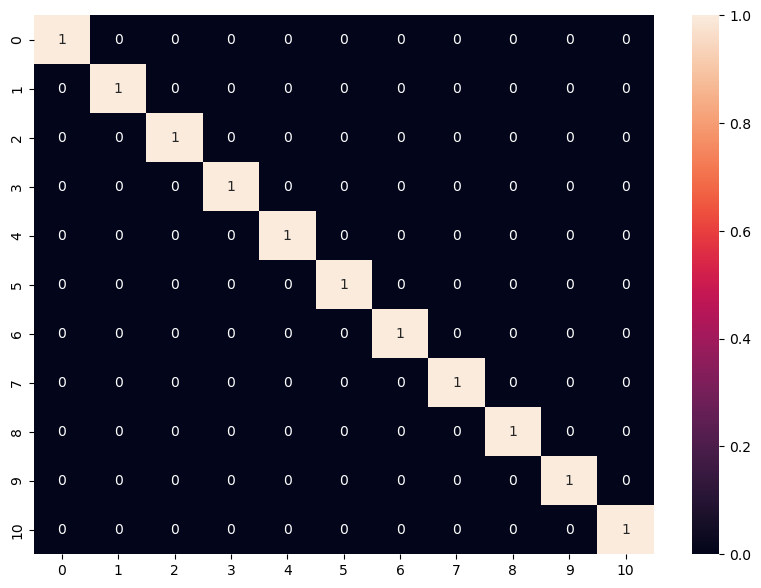

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_true_grapheme_root_new, y_pred_grapheme_root_new), annot=True)

<Axes: >

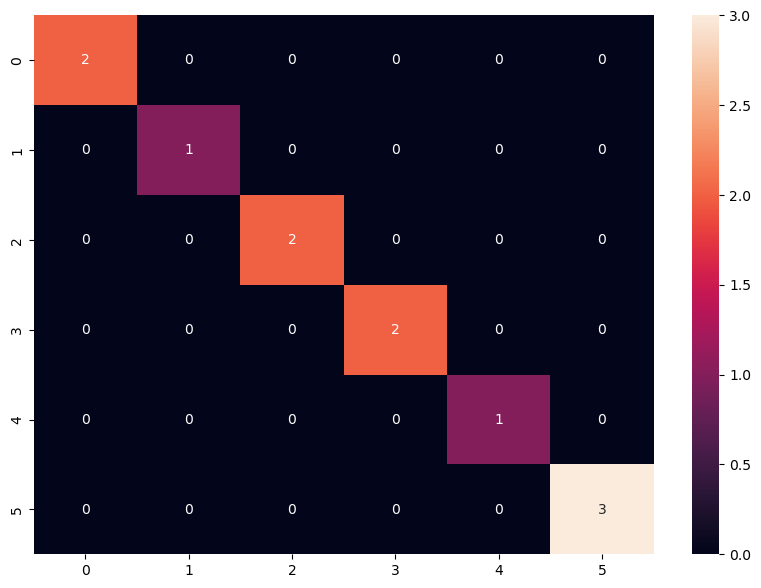

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_true_vowel_diacritic_new, y_pred_vowel_diacritic_new), annot=True)

<Axes: >

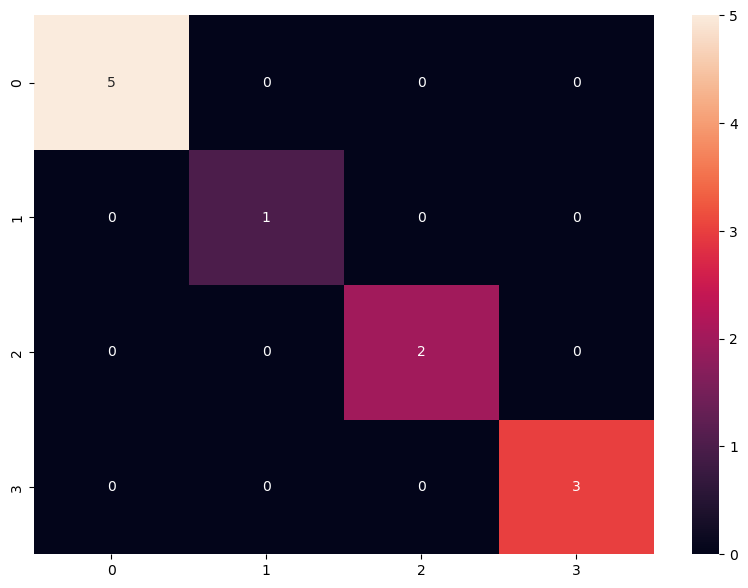

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_true_consonant_diacritic_new, y_pred_consonant_diacritic_new), annot=True)

In [ ]:
print("Accuracy score grapheme_root", accuracy_score(y_true_grapheme_root, y_pred_grapheme_root))

Accuracy score grapheme_root 1.0


In [ ]:
print("Accuracy score vowel_diacritic", accuracy_score(y_true_vowel_diacritic, y_pred_vowel_diacritic))

Accuracy score vowel_diacritic 1.0


In [ ]:
print("Accuracy score consonant_diacritic", accuracy_score(y_true_consonant_diacritic, y_pred_consonant_diacritic))

Accuracy score consonant_diacritic 0.0


In [ ]:
history.history

{'loss': [4.820860862731934,
  1.9032635688781738,
  1.3012878894805908,
  1.0314534902572632,
  0.8579843640327454,
  0.743175208568573,
  0.649434506893158,
  0.5717743635177612,
  0.5229386687278748,
  0.4788096249103546,
  0.3141796290874481,
  0.2649952471256256,
  0.24296844005584717,
  0.22252079844474792,
  0.20891742408275604,
  0.1952057033777237,
  0.18614129722118378,
  0.17445285618305206,
  0.16403591632843018,
  0.1582411825656891,
  0.15160228312015533,
  0.1434279829263687,
  0.13884709775447845,
  0.13351061940193176,
  0.12886777520179749,
  0.12427183985710144,
  0.1198338195681572,
  0.11597900092601776,
  0.11066026985645294,
  0.1067177876830101],
 'grapheme_root_loss': [3.447462558746338,
  1.4294092655181885,
  0.9601682424545288,
  0.7626522183418274,
  0.6386290192604065,
  0.5566982626914978,
  0.491282194852829,
  0.43401598930358887,
  0.4003700613975525,
  0.36736589670181274,
  0.2455451637506485,
  0.21218283474445343,
  0.19778954982757568,
  0.1826411

In [ ]:
print(get_grapheme(23,0, 0))

গ
